In [168]:
#% reset
import tensorflow as tf
import numpy as np
from tensorflow.python.ops import math_ops
import matplotlib.pyplot as plt
import time
import os
from tempfile import TemporaryFile
import random
import midi_musical_matrix
import data
import multi_training
from tensorflow.contrib.rnn import BasicLSTMCell
from tensorflow.contrib.rnn import LSTMStateTuple
from MyFunctions import Input_Kernel, LSTM_TimeWise_Training_Layer, LSTM_NoteWise_Layer, Loss_Function

# Plot configurations
% matplotlib inline
# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [169]:
# Import All Training and Validation Data
# Convert Entire Music .MIDI set to list of musical 'pieces'
# During training runs, getPieceBatch will return a tensor for Note_State_Batch, and corresponding Note_State_Expand
# Note_State_Expand will be fed into the graph input, and Note_State_Batch will be used for the loss function.


# Import Midi files to list
Working_Directory = os.getcwd()
Music_Directory = Working_Directory + "/Midi_Files/Piano_Midi/"
print(Working_Directory)
Midi_Directories = ["albeniz", "beeth", "borodin", "brahms", "burgm", "Chopin", "debussy", "granados", "grieg", "haydn", "liszt", "mendelssohn", "mozart", "muss", "schubert", "schumann", "tschai"]
max_time_steps = 256 # only files atleast this many 16th note steps are saved
num_validation_pieces=10


# Gather the training pieces from the specified directories
training_pieces={}
for f in range(len(Midi_Directories)):
    Training_Midi_Folder = Music_Directory + Midi_Directories[f]
    training_pieces = {**training_pieces, **multi_training.loadPieces(Training_Midi_Folder, max_time_steps)}

# Set aside a random set of pieces for validation purposes
validation_pieces={}
for v in range(num_validation_pieces):
    index = random.choice(list(training_pieces.keys()))
    validation_pieces[index] = training_pieces.pop(index)
    
    
print('')
print('Number of training pieces = ', len(training_pieces))    
print('Number of validation pieces = ', len(validation_pieces))     
    
    

# Generate sample Note State Matrix for dimension measurement and numerical checking purposes
# (Using external code to generate the Note State Matrix but using our own NoteInputForm (as defined in author's code) function
practice_batch_size = 15
practice_num_timesteps = 128

_, sample_state = multi_training.getPieceBatch(training_pieces, practice_batch_size, practice_num_timesteps)
sample_state = np.array(sample_state)
sample_state = np.swapaxes(sample_state, axis1=1, axis2=2)
print('Sample of State Input Batch: shape = ', sample_state.shape)






/home/ecbm4040/Music_Project/Generating_Music
Loaded alb_esp5
Loaded alb_esp2
Loaded appass_3
Loaded mond_1
Loaded beethoven_opus10_3
Loaded pathetique_3
Loaded waldstein_3
Loaded mond_3
Loaded beethoven_les_adieux_2
Loaded beethoven_opus22_4
Loaded waldstein_1
Loaded beethoven_hammerklavier_1
Loaded appass_2
Loaded beethoven_les_adieux_1
Loaded beethoven_opus22_1
Loaded beethoven_opus10_2
Loaded pathetique_1
Loaded beethoven_opus90_2
Loaded bor_ps7
Loaded bor_ps1
Loaded bor_ps5
Loaded brahms_opus1_1
Loaded brahms_opus1_2
Loaded br_rhap
Loaded burg_spinnerlied
Loaded burg_erwachen
Loaded burg_agitato
Loaded burg_gewitter
Loaded burg_trennung
Loaded burg_quelle
Loaded chpn-p23
Loaded chpn-p4
Loaded chpn_op35_4
Loaded chpn-p3
Loaded chpn-p14
Loaded chpn-p2
Loaded chpn_op25_e2
Loaded chpn_op25_e12
Loaded chpn-p16
Loaded chpn-p15
Loaded chpn_op25_e11
Loaded chpn_op25_e1
Loaded chpn_op27_1
Loaded chpn_op66
Loaded chpn_op35_3
Loaded chpn_op25_e4
Loaded chpn-p8
Loaded chpn_op35_1
Loaded DEB_P

In [170]:
# Build the Model Graph:
tf.reset_default_graph()
print('Building Graph...')
#Capture number of notes from sample
num_notes = sample_state.shape[1]

# Graph Input Placeholders
Note_State_Batch = tf.placeholder(dtype=tf.float32, shape=[None, num_notes, None, 2])
time_init = tf.placeholder(dtype=tf.int32, shape=())

#Generate expanded tensor from batch of note state matrices
# Essential the CNN 'window' of this network
Note_State_Expand = Input_Kernel(Note_State_Batch, Midi_low=24, Midi_high=101, time_init=time_init)

print('Note_State_Expand shape = ', Note_State_Expand.get_shape())


# lSTM Time Wise Training Graph 
num_t_units=[200, 200]
output_keep_prob = tf.placeholder(dtype=tf.float32, shape=())

# Generate initial state (at t=0) placeholder
timewise_state=[]
for i in range(len(num_t_units)):
    timewise_c=tf.placeholder(dtype=tf.float32, shape=[None, num_t_units[i]]) #None = batch_size * num_notes
    timewise_h=tf.placeholder(dtype=tf.float32, shape=[None, num_t_units[i]])
    timewise_state.append(LSTMStateTuple(timewise_h, timewise_c))

timewise_state=tuple(timewise_state)


timewise_out, timewise_state_out = LSTM_TimeWise_Training_Layer(input_data=Note_State_Expand, state_init=timewise_state, output_keep_prob=output_keep_prob)

print('Time-wise output shape = ', timewise_out.get_shape())




#LSTM Note Wise Graph

num_n_units = [100, 100]

# Generate initial state (at n=0) placeholder
notewise_state=[]
for i in range(len(num_n_units)):
    notewise_c=tf.placeholder(dtype=tf.float32, shape=[None, num_n_units[i]]) #None = batch_size * num_timesteps
    notewise_h=tf.placeholder(dtype=tf.float32, shape=[None, num_n_units[i]])
    notewise_state.append(LSTMStateTuple(notewise_h, notewise_c))

notewise_state=tuple(notewise_state)


y_out, note_gen_out = LSTM_NoteWise_Layer(timewise_out, state_init=notewise_state, output_keep_prob=output_keep_prob)

p_out = tf.sigmoid(y_out)
print('y_out shape = ', y_out.get_shape())
print('generated samples shape = ', note_gen_out.get_shape())



# Loss Function and Optimizer

loss, log_likelihood = Loss_Function(Note_State_Batch, y_out)
optimizer = tf.train.AdadeltaOptimizer(learning_rate = 1).minimize(loss)

print('Graph Building Complete')



Building Graph...
Note_State_Expand shape =  (?, 78, ?, 80)
Time-wise output shape =  (?, 78, ?, 200)
y_out shape =  (?, 78, ?, 2)
generated samples shape =  (?, 78, ?, 2)
Graph Building Complete


creating new destination folder
destination folder exists
Obtaining new batch of pieces
epoch =  0  /  50000 :
Training loss =  0.719033 ; Training log likelihood =  -56.0846
Validation loss =  0.694861 ; Validation log likelihood =  -54.1992
Obtaining new batch of pieces
epoch =  100  /  50000 :
Training loss =  0.223361 ; Training log likelihood =  -17.4221
Validation loss =  0.191227 ; Validation log likelihood =  -14.9157
Obtaining new batch of pieces
epoch =  200  /  50000 :
Training loss =  0.189458 ; Training log likelihood =  -14.7777
Validation loss =  0.162445 ; Validation log likelihood =  -12.6707
Obtaining new batch of pieces
epoch =  300  /  50000 :
Training loss =  0.205017 ; Training log likelihood =  -15.9913
Validation loss =  0.19684 ; Validation log likelihood =  -15.3535
Obtaining new batch of pieces
epoch =  400  /  50000 :
Training loss =  0.162583 ; Training log likelihood =  -12.6814
Validation loss =  0.195119 ; Validation log likelihood =  -15.2192
Obtaining 

Obtaining new batch of pieces
epoch =  4200  /  50000 :
Training loss =  0.109121 ; Training log likelihood =  -8.51145
Validation loss =  0.101464 ; Validation log likelihood =  -7.91421
Obtaining new batch of pieces
epoch =  4300  /  50000 :
Training loss =  0.104649 ; Training log likelihood =  -8.16258
Validation loss =  0.0944063 ; Validation log likelihood =  -7.36369
Obtaining new batch of pieces
epoch =  4400  /  50000 :
Training loss =  0.111827 ; Training log likelihood =  -8.72248
Validation loss =  0.102836 ; Validation log likelihood =  -8.02124
Obtaining new batch of pieces
epoch =  4500  /  50000 :
Training loss =  0.10109 ; Training log likelihood =  -7.88502
Validation loss =  0.0867734 ; Validation log likelihood =  -6.76833
Obtaining new batch of pieces
epoch =  4600  /  50000 :
Training loss =  0.105989 ; Training log likelihood =  -8.26714
Validation loss =  0.102249 ; Validation log likelihood =  -7.97539
Obtaining new batch of pieces
epoch =  4700  /  50000 :
Tra

Obtaining new batch of pieces
epoch =  8400  /  50000 :
Training loss =  0.0815827 ; Training log likelihood =  -6.36345
Validation loss =  0.0962575 ; Validation log likelihood =  -7.50808
Obtaining new batch of pieces
epoch =  8500  /  50000 :
Training loss =  0.0875826 ; Training log likelihood =  -6.83144
Validation loss =  0.0661432 ; Validation log likelihood =  -5.15917
Obtaining new batch of pieces
epoch =  8600  /  50000 :
Training loss =  0.089874 ; Training log likelihood =  -7.01017
Validation loss =  0.0854534 ; Validation log likelihood =  -6.66537
Obtaining new batch of pieces
epoch =  8700  /  50000 :
Training loss =  0.0772425 ; Training log likelihood =  -6.02491
Validation loss =  0.087714 ; Validation log likelihood =  -6.84169
Obtaining new batch of pieces
epoch =  8800  /  50000 :
Training loss =  0.0825996 ; Training log likelihood =  -6.44277
Validation loss =  0.0830553 ; Validation log likelihood =  -6.47831
Obtaining new batch of pieces
epoch =  8900  /  5000

epoch =  12500  /  50000 :
Training loss =  0.0775426 ; Training log likelihood =  -6.04833
Validation loss =  0.0791866 ; Validation log likelihood =  -6.17656
Obtaining new batch of pieces
epoch =  12600  /  50000 :
Training loss =  0.0773147 ; Training log likelihood =  -6.03054
Validation loss =  0.0763587 ; Validation log likelihood =  -5.95598
Obtaining new batch of pieces
epoch =  12700  /  50000 :
Training loss =  0.0791104 ; Training log likelihood =  -6.17061
Validation loss =  0.0618935 ; Validation log likelihood =  -4.82769
Obtaining new batch of pieces
epoch =  12800  /  50000 :
Training loss =  0.0811177 ; Training log likelihood =  -6.32718
Validation loss =  0.0892801 ; Validation log likelihood =  -6.96385
Obtaining new batch of pieces
epoch =  12900  /  50000 :
Training loss =  0.0774721 ; Training log likelihood =  -6.04282
Validation loss =  0.0916244 ; Validation log likelihood =  -7.1467
Obtaining new batch of pieces
Model saved in file: /home/ecbm4040/Music_Proj

Obtaining new batch of pieces
epoch =  16700  /  50000 :
Training loss =  0.0720487 ; Training log likelihood =  -5.6198
Validation loss =  0.0717333 ; Validation log likelihood =  -5.5952
Obtaining new batch of pieces
epoch =  16800  /  50000 :
Training loss =  0.0782019 ; Training log likelihood =  -6.09975
Validation loss =  0.0780243 ; Validation log likelihood =  -6.0859
Obtaining new batch of pieces
epoch =  16900  /  50000 :
Training loss =  0.0670464 ; Training log likelihood =  -5.22962
Validation loss =  0.070094 ; Validation log likelihood =  -5.46734
Obtaining new batch of pieces
Model saved in file: /home/ecbm4040/Music_Project/Generating_Music/Output/Long_Train/Long_Train
epoch =  17000  /  50000 :
Training loss =  0.0783706 ; Training log likelihood =  -6.11291
Validation loss =  0.0824384 ; Validation log likelihood =  -6.43019
Obtaining new batch of pieces
epoch =  17100  /  50000 :
Training loss =  0.0696454 ; Training log likelihood =  -5.43234
Validation loss =  0.0

Obtaining new batch of pieces
epoch =  20800  /  50000 :
Training loss =  0.0787329 ; Training log likelihood =  -6.14116
Validation loss =  0.0478963 ; Validation log likelihood =  -3.73591
Obtaining new batch of pieces
epoch =  20900  /  50000 :
Training loss =  0.0717435 ; Training log likelihood =  -5.59599
Validation loss =  0.0695249 ; Validation log likelihood =  -5.42295
Obtaining new batch of pieces
Model saved in file: /home/ecbm4040/Music_Project/Generating_Music/Output/Long_Train/Long_Train
epoch =  21000  /  50000 :
Training loss =  0.0837694 ; Training log likelihood =  -6.53401
Validation loss =  0.076765 ; Validation log likelihood =  -5.98767
Obtaining new batch of pieces
epoch =  21100  /  50000 :
Training loss =  0.0775579 ; Training log likelihood =  -6.04951
Validation loss =  0.0701209 ; Validation log likelihood =  -5.46943
Obtaining new batch of pieces
epoch =  21200  /  50000 :
Training loss =  0.0722139 ; Training log likelihood =  -5.63269
Validation loss =  

epoch =  24900  /  50000 :
Training loss =  0.0733326 ; Training log likelihood =  -5.71994
Validation loss =  0.0894904 ; Validation log likelihood =  -6.98025
Obtaining new batch of pieces
Model saved in file: /home/ecbm4040/Music_Project/Generating_Music/Output/Long_Train/Long_Train
epoch =  25000  /  50000 :
Training loss =  0.0840387 ; Training log likelihood =  -6.55502
Validation loss =  0.0688005 ; Validation log likelihood =  -5.36644
Obtaining new batch of pieces
epoch =  25100  /  50000 :
Training loss =  0.0682261 ; Training log likelihood =  -5.32164
Validation loss =  0.0885744 ; Validation log likelihood =  -6.90881
Obtaining new batch of pieces
epoch =  25200  /  50000 :
Training loss =  0.072816 ; Training log likelihood =  -5.67965
Validation loss =  0.0703803 ; Validation log likelihood =  -5.48966
Obtaining new batch of pieces
epoch =  25300  /  50000 :
Training loss =  0.0733706 ; Training log likelihood =  -5.72291
Validation loss =  0.0719635 ; Validation log lik

Model saved in file: /home/ecbm4040/Music_Project/Generating_Music/Output/Long_Train/Long_Train
epoch =  29000  /  50000 :
Training loss =  0.0624388 ; Training log likelihood =  -4.87022
Validation loss =  0.0723693 ; Validation log likelihood =  -5.64481
Obtaining new batch of pieces
epoch =  29100  /  50000 :
Training loss =  0.0728466 ; Training log likelihood =  -5.68204
Validation loss =  0.0742343 ; Validation log likelihood =  -5.79028
Obtaining new batch of pieces
epoch =  29200  /  50000 :
Training loss =  0.0783631 ; Training log likelihood =  -6.11232
Validation loss =  0.0571787 ; Validation log likelihood =  -4.45994
Obtaining new batch of pieces
epoch =  29300  /  50000 :
Training loss =  0.0665875 ; Training log likelihood =  -5.19382
Validation loss =  0.0876849 ; Validation log likelihood =  -6.83942
Obtaining new batch of pieces
epoch =  29400  /  50000 :
Training loss =  0.0790824 ; Training log likelihood =  -6.16843
Validation loss =  0.0849573 ; Validation log li

Obtaining new batch of pieces
epoch =  33100  /  50000 :
Training loss =  0.0735246 ; Training log likelihood =  -5.73492
Validation loss =  0.0578864 ; Validation log likelihood =  -4.51514
Obtaining new batch of pieces
epoch =  33200  /  50000 :
Training loss =  0.0708515 ; Training log likelihood =  -5.52642
Validation loss =  0.0772582 ; Validation log likelihood =  -6.02614
Obtaining new batch of pieces
epoch =  33300  /  50000 :
Training loss =  0.0608715 ; Training log likelihood =  -4.74797
Validation loss =  0.0628394 ; Validation log likelihood =  -4.90148
Obtaining new batch of pieces
epoch =  33400  /  50000 :
Training loss =  0.0714671 ; Training log likelihood =  -5.57443
Validation loss =  0.0805055 ; Validation log likelihood =  -6.27943
Obtaining new batch of pieces
epoch =  33500  /  50000 :
Training loss =  0.0767526 ; Training log likelihood =  -5.98671
Validation loss =  0.0703581 ; Validation log likelihood =  -5.48793
Obtaining new batch of pieces
epoch =  33600 

Obtaining new batch of pieces
epoch =  37200  /  50000 :
Training loss =  0.0642854 ; Training log likelihood =  -5.01426
Validation loss =  0.0611859 ; Validation log likelihood =  -4.7725
Obtaining new batch of pieces
epoch =  37300  /  50000 :
Training loss =  0.0632482 ; Training log likelihood =  -4.93336
Validation loss =  0.0610565 ; Validation log likelihood =  -4.76241
Obtaining new batch of pieces
epoch =  37400  /  50000 :
Training loss =  0.0734933 ; Training log likelihood =  -5.73248
Validation loss =  0.0650141 ; Validation log likelihood =  -5.0711
Obtaining new batch of pieces
epoch =  37500  /  50000 :
Training loss =  0.0628451 ; Training log likelihood =  -4.90192
Validation loss =  0.076301 ; Validation log likelihood =  -5.95148
Obtaining new batch of pieces
epoch =  37600  /  50000 :
Training loss =  0.0804732 ; Training log likelihood =  -6.27691
Validation loss =  0.0558363 ; Validation log likelihood =  -4.35523
Obtaining new batch of pieces
epoch =  37700  / 

epoch =  41300  /  50000 :
Training loss =  0.0740157 ; Training log likelihood =  -5.77323
Validation loss =  0.0636058 ; Validation log likelihood =  -4.96125
Obtaining new batch of pieces
epoch =  41400  /  50000 :
Training loss =  0.057373 ; Training log likelihood =  -4.47509
Validation loss =  0.0768962 ; Validation log likelihood =  -5.9979
Obtaining new batch of pieces
epoch =  41500  /  50000 :
Training loss =  0.0685579 ; Training log likelihood =  -5.34752
Validation loss =  0.0585987 ; Validation log likelihood =  -4.5707
Obtaining new batch of pieces
epoch =  41600  /  50000 :
Training loss =  0.0726701 ; Training log likelihood =  -5.66827
Validation loss =  0.0652009 ; Validation log likelihood =  -5.08567
Obtaining new batch of pieces
epoch =  41700  /  50000 :
Training loss =  0.078732 ; Training log likelihood =  -6.14109
Validation loss =  0.0693499 ; Validation log likelihood =  -5.40929
Obtaining new batch of pieces
epoch =  41800  /  50000 :
Training loss =  0.075

epoch =  45400  /  50000 :
Training loss =  0.0573689 ; Training log likelihood =  -4.47478
Validation loss =  0.0696783 ; Validation log likelihood =  -5.43491
Obtaining new batch of pieces
epoch =  45500  /  50000 :
Training loss =  0.0687033 ; Training log likelihood =  -5.35886
Validation loss =  0.0776519 ; Validation log likelihood =  -6.05685
Obtaining new batch of pieces
epoch =  45600  /  50000 :
Training loss =  0.0689305 ; Training log likelihood =  -5.37658
Validation loss =  0.080304 ; Validation log likelihood =  -6.26371
Obtaining new batch of pieces
epoch =  45700  /  50000 :
Training loss =  0.0718405 ; Training log likelihood =  -5.60356
Validation loss =  0.0764882 ; Validation log likelihood =  -5.96608
Obtaining new batch of pieces
epoch =  45800  /  50000 :
Training loss =  0.0629549 ; Training log likelihood =  -4.91048
Validation loss =  0.0876708 ; Validation log likelihood =  -6.83832
Obtaining new batch of pieces
epoch =  45900  /  50000 :
Training loss =  0.

Obtaining new batch of pieces
epoch =  49600  /  50000 :
Training loss =  0.0688503 ; Training log likelihood =  -5.37032
Validation loss =  0.0761342 ; Validation log likelihood =  -5.93847
Obtaining new batch of pieces
epoch =  49700  /  50000 :
Training loss =  0.0681697 ; Training log likelihood =  -5.31723
Validation loss =  0.0652975 ; Validation log likelihood =  -5.0932
Obtaining new batch of pieces
epoch =  49800  /  50000 :
Training loss =  0.0702423 ; Training log likelihood =  -5.4789
Validation loss =  0.0695327 ; Validation log likelihood =  -5.42355
Obtaining new batch of pieces
epoch =  49900  /  50000 :
Training loss =  0.0762505 ; Training log likelihood =  -5.94754
Validation loss =  0.0674798 ; Validation log likelihood =  -5.26343
Obtaining new batch of pieces
Model saved in file: /home/ecbm4040/Music_Project/Generating_Music/Output/Long_Train/Long_Train
epoch =  50000  /  50000 :
Training loss =  0.0673102 ; Training log likelihood =  -5.25019
Validation loss =  0

<function matplotlib.pyplot.show>

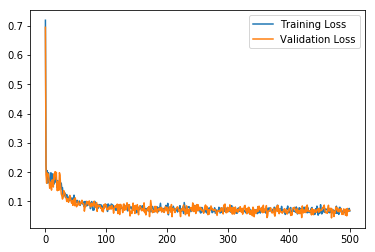

In [171]:
# Training

start_time = time.time()
N_epochs = 50000
loss_hist=[]
loss_valid_hist=[]
restore_model_name = None
save_model_name = 'Long_Train'
batch_size = 10
num_timesteps = 128
keep_prob=.5

# Save Model
Output_Directory = Working_Directory + "/Output/" + save_model_name
directory = os.path.dirname(Output_Directory)

try:
    print('creating new destination folder')
    os.mkdir(directory)    
except:
    print('destination folder exists')
            

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    
    # try to restore the pre_trained
    if restore_model_name is not None:
        Load_Directory = Working_Directory + "/Output/" + restore_model_name
               
        print("Load the model from: {}".format(restore_model_name))
        saver.restore(sess, Load_Directory + '/{}'.format(restore_model_name))
        
    
    # Initial States
    timewise_state_val=[]
    for i in range(len(num_t_units)):
        c_t = np.zeros((batch_size*num_notes, num_t_units[i])) #start every batch with zero state in LSTM time cells
        h_t = np.zeros((batch_size*num_notes, num_t_units[i]))
        timewise_state_val.append(LSTMStateTuple(h_t, c_t))
        
    notewise_state_val=[]
    for i in range(len(num_n_units)):
        c_n = np.zeros((batch_size*num_timesteps, num_n_units[i])) #start every batch with zero state in LSTM time cells
        h_n = np.zeros((batch_size*num_timesteps, num_n_units[i]))
        notewise_state_val.append(LSTMStateTuple(h_n, c_n))
    
  

    # Training Loop
    for epoch in range(N_epochs+1):
        
        # Generate random batch of training data        
        if (epoch % 100 == 0):         
            print('Obtaining new batch of pieces')
            _, batch_input_state = multi_training.getPieceBatch(training_pieces, batch_size, num_timesteps) # not using their 'convolution' filter
            batch_input_state = np.array(batch_input_state)
            batch_input_state = np.swapaxes(batch_input_state, axis1=1, axis2=2)           
       

        # Run Session
        feed_dict = {Note_State_Batch: batch_input_state, timewise_state: timewise_state_val, notewise_state: notewise_state_val, time_init: 0, output_keep_prob: keep_prob}
        loss_run, log_likelihood_run, _, note_gen_out_run = sess.run([loss, log_likelihood, optimizer, note_gen_out], feed_dict=feed_dict)

        
        # Periodically save model and loss histories
        if (epoch % 1000 == 0) & (epoch > 0):
            save_path = saver.save(sess, Output_Directory + '/{}'.format(save_model_name))
            print("Model saved in file: %s" % save_path)
            np.save(Output_Directory + "/ training_loss.npy", loss_hist)
            np.save(Output_Directory + "/ valid_loss.npy", loss_valid)
        
        # Regularly Calculate Validation loss and store both training and validation losses
        if (epoch % 100) == 0 & (epoch > 0):
            # Calculation Validation loss
            _, batch_input_state_valid = multi_training.getPieceBatch(validation_pieces, batch_size, num_timesteps) # not using their 'convolution' filter
            batch_input_state_valid = np.array(batch_input_state_valid)
            batch_input_state_valid = np.swapaxes(batch_input_state_valid, axis1=1, axis2=2)    
            feed_dict = {Note_State_Batch: batch_input_state_valid, timewise_state: timewise_state_val, notewise_state: notewise_state_val, time_init: 0, output_keep_prob: keep_prob}
            loss_valid, log_likelihood_valid = sess.run([loss, log_likelihood], feed_dict=feed_dict)
            
            print('epoch = ', epoch, ' / ', N_epochs, ':')
            print('Training loss = ', loss_run, '; Training log likelihood = ', log_likelihood_run)
            print('Validation loss = ', loss_valid, '; Validation log likelihood = ', log_likelihood_valid)
            
            loss_hist.append(loss_run)
            loss_valid_hist.append(loss_valid)
        
        # Periodically generate Sample of music
            

end_time = time.time()

print('Training time = ', end_time - start_time, ' seconds')

# Plot the loss histories
plt.plot(loss_hist, label="Training Loss")
plt.plot(loss_valid_hist, label="Validation Loss")
plt.legend()
plt.show

Load the model from: Piano_Midi2
INFO:tensorflow:Restoring parameters from /home/ecbm4040/Music_Project/Generating_Music/Output/Piano_Midi2/Piano_Midi2


INFO:tensorflow:Restoring parameters from /home/ecbm4040/Music_Project/Generating_Music/Output/Piano_Midi2/Piano_Midi2


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<function matplotlib.pyplot.show>

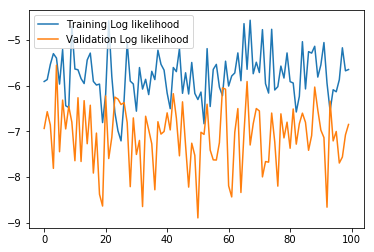

In [117]:
# Generate Final Test and Validation Likelihoods 
keep_prob=1
training_loss_ave=[]
validation_loss_ave=[]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # try to restore the pre_trained
    if restore_model_name is not None:
        print("Load the model from: {}".format(save_model_name))
        saver.restore(sess, Load_Directory + '/{}'.format(save_model_name))
    
    # Initial States
    timewise_state_val=[]
    for i in range(len(num_t_units)):
        c_t = np.zeros((batch_size*num_notes, num_t_units[i])) #start every batch with zero state in LSTM time cells
        h_t = np.zeros((batch_size*num_notes, num_t_units[i]))
        timewise_state_val.append(LSTMStateTuple(h_t, c_t))
        
    notewise_state_val=[]
    for i in range(len(num_n_units)):
        c_n = np.zeros((batch_size*num_timesteps, num_n_units[i])) #start every batch with zero state in LSTM time cells
        h_n = np.zeros((batch_size*num_timesteps, num_n_units[i]))
        notewise_state_val.append(LSTMStateTuple(h_n, c_n))
        
    for p in range(10):
        _, batch_input_state_test = multi_training.getPieceBatch(training_pieces, batch_size, num_timesteps) # not using their 'convolution' filter
        batch_input_state_test = np.array(batch_input_state_test)
        batch_input_state_test = np.swapaxes(batch_input_state_test, axis1=1, axis2=2) 
        
        # Run Session
        feed_dict = {Note_State_Batch: batch_input_state_test, timewise_state: timewise_state_val, notewise_state: notewise_state_val, time_init: 0, output_keep_prob: 1}
        loss_run, log_likelihood_run, note_gen_out_run = sess.run([loss, log_likelihood, note_gen_out], feed_dict=feed_dict)                                                           
        training_loss_ave.append(-78*loss_run)
        
        _, batch_input_state_valid = multi_training.getPieceBatch(validation_pieces, batch_size, num_timesteps) # not using their 'convolution' filter
        batch_input_state_valid = np.array(batch_input_state_valid)
        batch_input_state_valid = np.swapaxes(batch_input_state_valid, axis1=1, axis2=2) 
        
        # Run Session
        feed_dict = {Note_State_Batch: batch_input_state_valid, timewise_state: timewise_state_val, notewise_state: notewise_state_val, time_init: 0, output_keep_prob: 1}
        loss_run, log_likelihood_run, note_gen_out_run = sess.run([loss, log_likelihood, note_gen_out], feed_dict=feed_dict)                                                              
        validation_loss_ave.append(-78*loss_run)
        
        print(p) 
        

# Plot the final loss 
plt.plot(training_loss_ave, label="Training Log likelihood")
plt.plot(validation_loss_ave, label="Validation Log likelihood")
plt.legend()
plt.show

In [172]:
# Music Generation

"""
    Music Generation
    input = initial note vector
    for t = 1:Tsong
    input --> input kernel
    run through 1 'call' of Model LSTM with present parameters / states
    run through note-wise LSTM block as normally done to produce vector of generated samples
    input = generated samples
    music_sequence.append(input)
    store batch of music sequences in .MIDI files
"""
T_gen=32*16
batch_gen_size=10
keep_prob=1  
music_model_name = save_model_name
    
#Load Model
Load_Directory = Working_Directory + "/Output/" + music_model_name
directory = os.path.dirname(Load_Directory)


try:
    os.mkdir(directory)       
except:
    print('directory exists')
    

# start with initial Note_State_Batch with 't' dimension = 1 (can still a batch of samples run in parallel)
notes_gen_initial = np.zeros((batch_gen_size, num_notes, 1,2))

# Initial States
notes_gen = notes_gen_initial
    
timewise_state_val=[]
for i in range(len(num_t_units)):
    c = np.zeros((batch_gen_size*num_notes, num_t_units[i])) #start first time step with zero state in LSTM time cells
    h = np.zeros((batch_gen_size*num_notes, num_t_units[i]))
    timewise_state_val.append(LSTMStateTuple(h, c))
        
notewise_state_val=[]
for i in range(len(num_n_units)):
    c = np.zeros((batch_gen_size*1, num_n_units[i])) #start every batch with zero state in LSTM time cells
    h = np.zeros((batch_gen_size*1, num_n_units[i]))
    notewise_state_val.append(LSTMStateTuple(h, c))
        
notes_gen_arr=[]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    
    print("Load the model from: {}".format(music_model_name))
    saver.restore(sess, Load_Directory + '/{}'.format(music_model_name))
    

    for t in range(T_gen):
        feed_dict = {Note_State_Batch: notes_gen, timewise_state: timewise_state_val, notewise_state: notewise_state_val, time_init: t % 16, output_keep_prob: keep_prob}    
        timewise_state_val, notes_gen = np.squeeze(sess.run([timewise_state_out, note_gen_out], feed_dict = feed_dict), axis=2)
        notes_gen_arr.append(np.squeeze(notes_gen))
        
        
        
        if t % 50 == 0:
            print('Timestep = ', t)
    


        
# Save Generate Notes to .MIDI file
notes_gen_out = np.stack(notes_gen_arr, axis=2)
notes_gen_out = np.swapaxes(notes_gen_out, axis1=1, axis2=2)
    
for iter in range(batch_gen_size):
    file = Load_Directory + "/Epoch " + str(epoch) + " Music" + str(iter)
    midi_out = midi_musical_matrix.noteStateMatrixToMidi(notes_gen_out[iter,:,:,:], name=file)
    
print('Midi files saved')   

    

directory exists
Load the model from: Long_Train
INFO:tensorflow:Restoring parameters from /home/ecbm4040/Music_Project/Generating_Music/Output/Long_Train/Long_Train


INFO:tensorflow:Restoring parameters from /home/ecbm4040/Music_Project/Generating_Music/Output/Long_Train/Long_Train


Timestep =  0
Timestep =  50
Timestep =  100
Timestep =  150
Timestep =  200
Timestep =  250
Timestep =  300
Timestep =  350
Timestep =  400
Timestep =  450
Timestep =  500
Midi files saved
